# Chapter 4: Regime Definition

1. Import libraries
2. Utilities Files
    2.1. Utilities Functions
    2.2. Charting Functions using mpf library
3. Download benchmark & currency historical prices
4. Download historical prices autos
5. Define regime functions:

    1. Breakout
    2. Turtle Trader
    3. Moving Averages: SMA, EMA
    4. Fractal
    5. HigherHighs
    6. Floor & Ceiling
    7. Score

6. Set-up & Initialise arcticDB
7. Data manipulation across the investment universe
8. Fractals in Production
9. Searching for the 5-minute bar that triggered the bear avalanche

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import pathlib
import arcticdb as adb
from arcticdb import LibraryOptions

import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import mplfinance as mpf


## 2. Utilities Functions

#### 2.1. Utilities Functions:

def path_folder(folder, home = False): save and retrieve files in a folder

def batch_px_df(tickers_list,batch_size, start, end,show_batch = False): download historical close prices using yfinance library

def df_from_dict(batch_size,dct,start,end): uses previous function to download historical prices from a dictionary {ticker: name}

def batch_df(tickers_list,batch_size, start, end,show_batch = False): download historical OHLCV prices 

def yf_droplevel(batch_download,ticker): get single security OHLCV from multiindex dataframe

def multiindex_from_dict(df_dict, yf_format=False): creates a multiindex dataframe from a dictionary {ticker:df}. To have a similar order than the yfinance. then set boolean to True

def rohlc(df,relative = False): instantiate absolute/relative OHLC

def rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = False, mult = 1000): calculate relative series benchmarked, currency adjusted

def last_row_cols_dict(df,ticker,df_cols): creates a dictionary of {ticker: last_value}

def col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ' ): prefix for relative and absoute series

def sector_avg_df(df_table, target_col, df_historical): Calculates sector historical average


In [2]:
# Utiities Functions:

def path_folder(folder, home = False):
    if home == True:
        directory = pathlib.Path.home() /  folder
    else:
        directory = pathlib.Path.cwd() / folder
        
    if not directory.exists():
        directory.mkdir(parents=True, exist_ok=True)    
    return directory

def batch_px_df(tickers_list,batch_size, start, end,show_batch = False):
    px_df = pd.DataFrame()
    loop_size = int(len(tickers_list) // batch_size) + 2
    for t in range(1,loop_size): # Batch download
        try:
            m = (t - 1) * batch_size
            n = t * batch_size
            batch_list = tickers_list[m:n]
            if show_batch:
                print(batch_list,m,n)
            batch_download = yf.download(tickers= batch_list,start= start, end = end, interval = "1d",
                                group_by = 'column',auto_adjust = True, prepost = True)['Close']
            px_df = px_df.join(batch_download, how='outer')
        except:
            pass
    return px_df

def df_from_dict(batch_size,dct,start,end):
    tickers_list = list(dct.keys())
    df = batch_px_df(tickers_list,batch_size, start, end,show_batch = False)
    df = df.rename(columns = dct)
    df = df.tz_localize(None).ffill()
    return df

def batch_df(tickers_list,batch_size, start, end,show_batch = False):
    px_df = pd.DataFrame()
    loop_size = int(len(tickers_list) // batch_size) + 2
    for t in range(1,loop_size): # Batch download
        try:
            m = (t - 1) * batch_size
            n = t * batch_size
            batch_list = tickers_list[m:n]
            if show_batch:
                print(batch_list,m,n)
            batch_download = yf.download(tickers= batch_list,start= start, end = end, interval = "1d",
                                group_by = 'column',auto_adjust = True, prepost = True)
            px_df = pd.concat([px_df, batch_download], axis = 1)
        except:
            pass
        # px_df = px_df.tz_localize(None).ffill()
    return px_df

def yf_droplevel(batch_download,ticker):
    df = batch_download.iloc[:, batch_download.columns.get_level_values(1) == ticker]
    df.columns = df.columns.droplevel(1)
    df = df.dropna()
    return df

def multiindex_from_dict(df_dict, yf_format=False):
    multi_df = pd.concat(df_dict, axis=1)
    multi_df = multi_df.reindex(multi_df.columns, axis=1)
    if yf_format:
        multi_df.columns = multi_df.columns.reorder_levels([1, 0])
    return multi_df

def rohlc(df,relative = False):
    if relative==True:
        rel = 'r'
    else:
        rel= ''      
    if 'Open' in df.columns:
       _o,_h,_l,_c = f'{rel}Open',f'{rel}High',f'{rel}Low',f'{rel}Close'      
    elif 'open' in df.columns:
        _o,_h,_l,_c = f'{rel}open',f'{rel}high',f'{rel}low',f'{rel}close'
    else:
        _o=_h=_l=_c= np.nan
    return _o,_h,_l,_c

def rel_fx(df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase = False, mult = 1000):
    df[ccy] = ccy_df.loc[start:end,ccy].copy().ffill()
    df[bm] = bm_df.loc[start:end,bm].copy().ffill()
    for i in [_o,_h,_l,_c]:
        df[f'r{i}'] = df[i].div(df[ccy])
        if rebase == True:
            df[f'r{i}'] = df[f'r{i}'].div(df[bm]).mul(df[df[bm].notna()].iloc[0,list(df.columns).index(bm)])
        else:
            df[f'r{i}'] = df[f'r{i}'].div(df[bm]) * mult
    return df

def last_row_cols_dict(df,ticker,df_cols):
    last_row_idx = df.index.max()
    col_dict = {'ticker':str.upper(ticker),'date':df.index.max()}
    for col in df_cols:
        if pd.isnull(df.loc[last_row_idx,col]):
            try:
                last_idx = df[pd.notnull(df.loc[:,col])].index[-1]
                col_dict.update({f'{col}_dt': last_idx})
                col_dict.update({col : df.loc[last_idx,col]})
            except:
                col_dict.update({f'{col}_dt': np.nan})
                col_dict.update({col : np.nan})
        else:
            col_dict.update({col : df.loc[last_row_idx,col]})
    return col_dict

def col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ' ):
    if rel == False:
        col_name = name_abs
    elif rel == True:
        col_name = name_rel
    return col_name

def sector_avg_df(df_table, target_col, df_historical):
    """
    Calculate the average absolute bullish/bearish count for each sector.
    """
    df_historical = df_historical.copy().dropna(how='all', axis=1)    
    df_historical.columns.names = ['ticker']
    sector_df = pd.concat([df_table[[target_col]], df_historical.T], axis=1)
    sector_avg_df = pd.pivot_table(sector_df, values=list(df_historical.index), index=[target_col], aggfunc="mean").T
    return sector_avg_df

#### 2.2. Charting Functions using mpf library

def mpf_score(data, score_list, alfa, color_bull, color_bear,  pane, vlabel): This function fills colours depending on the regime for the absolute, relative and composite bullish/bearish scores.

def mpf_relative(data, rel, sma_list, pane, color= 'grey'): This function creates a separate pane for the relative series. Note that the relative ‘Close’ price is displayed in a line.

def mpf_fill(data,_min, _max, color_bull, color_bear, alfa, pane, field): This function fills the space between a line and the ‘Close’ price. There are four categories: 

1.	bull_profit colored in color_bull when regime is bull and price is above the line
2.	bull_loss colored in color_bear when regime is bull and price is below the line
3.	bear_profit colored in color_bull when regime is bear and price is below the line
4.	bull_loss colored in color_bear when regime is bear and price is above the line


def mpf_fractals(data,col_name, fractals_list, color_up, color_down, size, pane): This function draws up and down triangles at swing highs and lows. The size and opacity of the triangles varies based on the level of abstraction

In [3]:
# Charting Functions:
def mpf_score(data, score_list, alfa, color_bull, color_bear,  pane, vlabel):
    score_fill = []
    for r,scr in enumerate(score_list):
        if (scr in data.columns):
            if (data[scr].sum() != 0):
                score_bull = dict(y1= 0, y2= data[scr].values , alpha= alfa / (r+1), color= color_bull,
                                where = (data[scr].values >= 0))
                score_fill.append(score_bull)            
                score_bear = dict(y1= data[scr].values, y2= 0 , alpha= alfa / (r+1), color= color_bear,
                                        where = (data[scr].values<= 0))
                score_fill.append(score_bear)
                score = mpf.make_addplot(data[scr], fill_between = score_fill,color='blue',
                                          alpha = alfa/(r+1), panel= pane, ylabel = vlabel)
                subplots.append(score)
                
def mpf_relative(data, rel, sma_list, pane, color= 'grey'):
    if (rel == True):
        _o,_h,_l,_c = rohlc(data,relative = rel)
        if (_c in data.columns):
            rel_plot = mpf.make_addplot(data[_c],type='line', color = color, ylabel = str(_c),alpha =1, mav = tuple(sorted(sma_list)),
                                                 panel = pane)
            subplots.append(rel_plot)

def mpf_fill(data,_min, _max, color_bull, color_bear, alfa, pane, field): 
    fill_mpf = []
    bull_profit = dict(y1= _min.values, y2= data[_c].values, alpha= alfa, color= color_bull,                        
                   where = (data[field].values > 0) & (_min.values < data[_c].values))
    fill_mpf.append(bull_profit)
    bull_loss =  dict(y1= _min.values, y2= data[_c].values, alpha= alfa/2, color= color_bear, 
                   where = (data[field].values > 0) & (_min.values > data[_c].values))
    fill_mpf.append(bull_loss)
    
    bear_profit = dict(y1= _max.values, y2= data[_c].values, alpha= alfa, color= color_bear,
                   where = (data[field].values < 0) & (_max.values > data[_c].values))
    fill_mpf.append(bear_profit)     
    bear_loss = dict(y1= _max.values, y2= data[_c].values, alpha= alfa/2, color= color_bull,
                   where = (data[field].values < 0) & (_max.values < data[_c].values))
    fill_mpf.append(bear_loss)  
        
    plot_fill = mpf.make_addplot(data[_c],fill_between = fill_mpf,color='blue', alpha=0 , panel= pane)
    subplots.append(plot_fill)    

def mpf_fractals(data,col_name, fractals_list, color_up, color_down, size, pane):     
    for f in fractals_list:
        if (f'{col_name}Hi{f}' in data.columns): 
            if (data[f'{col_name}Hi{f}'].count()>0):
                fractal_down = mpf.make_addplot(data[f'{col_name}Hi{f}'], type= 'scatter', markersize= int(size*f/max(fractals_list)) , 
                                                marker= 'v', color= color_down, alpha = f/max(fractals_list),panel = pane)
                subplots.append(fractal_down)
            
        if (f'{col_name}Lo{f}' in data.columns):
            if (data[f'{col_name}Lo{f}'].count() >0):
                fractal_up = mpf.make_addplot(data[f'{col_name}Lo{f}'], type= 'scatter', markersize= int(size*f/max(fractals_list)) , 
                                    marker= '^', color= color_up, alpha = f/max(fractals_list),panel = pane)
                subplots.append(fractal_up)
        
        if not (f'{col_name}Hi{f}' in data.columns) and not (f'{col_name}Lo{f}' in data.columns):            
            break
        


## 3. Download benchmark & currency historical prices

1. Instantiate variables
2. start_mpf = -550, mpf defaults to line charts for longer series. OHLC bars are available for series < 600 periods
3. Create benchmark bm_df and currency ccy_df

In [4]:
batch_size = 51 ; start= '2015-01-01' ; end = None
bm_ticker = 'SP500'    ; ccy = 'local'
st,lt, xlt = 20,50,100 ; bo_list = [st,lt,xlt] ; sma_list = [lt,st] ; n = 30
rel_list = [True,False] ; score_list = ['score','score_rel','score_abs']

start_mpf= -550  ; alfa = 0.6 ; color_bull = 'lightblue' ; color_bear = 'lightpink' ; color_down = 'r' ; color_up = 'g' ; size = 24

In [5]:
dict_bm =  {'^GSPC':'SP500','^DJI':'DOW30','^IXIC':'Nasdaq100','^NYA':'NYSE ','^XAX':'Nyse_Amex','^RUT':'Russell2000','^VIX':'VIX',
'^BUK100P':'CBOEUK100','^FTSE':'FTSE100','^GDAXI':'DAX','^FCHI':'CAC40','^STOXX50E':'EuroStocks50','^N100':'Euronext100','^BFX':'BEL20',
'^N225':'Nikkei225','^HSI':'HangSeng','000001.SS':'SSE','399001.SZ':'Shenzhen'} 

dict_ccy = {'EURUSD=X':'EURUSD','JPY=X':'USDJPY','GBPUSD=X':'GBPUSD','AUDUSD=X':'AUDUSD',
            'NZDUSD=X':'NZDUSD', 'USDCAD=X': 'USDCAD','EURJPY=X':'EURJPY', 'GBPJPY=X':'GBPJPY','EURGBP=X':'EURGBP',
            'EURCAD=X':'EURCAD','EURSEK=X':'EURSEK','EURCHF=X':'EURCHF','CNY=X':'USDCNY','HKD=X':'USDHKD',
            'SGD=X':'USDSGD','INR=X':'USDINR','KRW=X' : 'USDKRW', 'TWD=X': 'USDTWD',}

ccy_df = df_from_dict(batch_size,dict_ccy,start,end)
ccy_df['local'] = 1
bm_df = df_from_dict(batch_size,dict_bm,start,end).round(2)
bm_df['absolute'] = 1

print(bm_df.shape, ccy_df.shape)

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  18 of 18 completed

(2734, 19) (2737, 19)


## 4. Download historical prices autos

Toyota (7203.T), Nissan (7201.T), BYD (1211.HK), Hyundai Motors (005380.KS), Volkswagen (VOW3.DE), Renault (RNO.PA), Ford (F), Tesla (TSLA) and General Motors (GM).

Next, we pick one stock to illustrate various regime methods: 7201.T Nissan, "the Rolls Royce of short-sellers" pun intended

In [6]:
bm = 'SP500'
tickers_fx_dict = {'7203.T': 'USDJPY', '7201.T': 'USDJPY','1211.HK':'USDHKD','005380.KS':'USDKRW','VOW3.DE' :'EURUSD', 'RNO.PA':'EURUSD','F':'local' ,'TSLA':'local' ,'GM':'local'  }
tickers_list = list(tickers_fx_dict.keys())

multiIndex_raw_data = batch_df(tickers_list,batch_size, start, end,show_batch = False).round(2)
multiIndex_raw_data.tail()

[*********************100%***********************]  9 of 9 completed


Price          Close                                                      \
Ticker     005380.KS 1211.HK 7201.T  7203.T      F     GM RNO.PA    TSLA   
Date                                                                       
2025-06-30  203500.0   122.5  350.2  2493.0  10.85  49.21  39.13  317.66   
2025-07-01  210000.0     NaN  341.8  2453.0  11.35  52.03  40.17  300.71   
2025-07-02  213500.0   122.3  342.6  2465.5  11.77  52.68  41.23  315.65   
2025-07-03  214500.0   123.0  362.1  2511.5  11.81  52.89  40.74  315.35   
2025-07-04  210500.0   121.5  354.3  2484.5    NaN    NaN  40.54     NaN   

Price                   High  ...    Open     Volume                          \
Ticker     VOW3.DE 005380.KS  ... VOW3.DE  005380.KS     1211.HK      7201.T   
Date                          ...                                              
2025-06-30   91.34  207000.0  ...   91.34   492507.0  23186063.0  29758700.0   
2025-07-01   91.34  214500.0  ...   91.34  1059697.0         NaN  21246700.0   
2025-07-02   90.94  218000.0  ...   90.16  1058819.0  27281940.0  17744600.0   
2025-07-03   91.10  217000.0  ...   92.02   562758.0  17122687.0  44076800.0   
2025-07-04   90.02  216500.0  ...   90.60   415693.0  20263203.0  17792500.0   

Price                                                                    \
Ticker          7203.T            F          GM     RNO.PA         TSLA   
Date                                                                      
2025-06-30  29284500.0   88472200.0   9634700.0  1211249.0   76695100.0   
2025-07-01  24298200.0  140150700.0  13748000.0  1498957.0  145085700.0   
2025-07-02  24281200.0  122331600.0   9459100.0  1396071.0  119191500.0   
2025-07-03  34098600.0   60311500.0   6612300.0   816072.0   58042300.0   
2025-07-04  19876900.0          NaN         NaN   572983.0          NaN   

Price                 
Ticker       VOW3.DE  
Date                  
2025-06-30       0.0  
2025-07-01       0.0  
2025-07-02  990911.0  
2025-07-03  593824.0  
2025-07-04  622736.0  

[5 rows x 45 columns]

Pick one stock as an example: Nissan,m the Rolls Royce of Short-sellers

In [7]:
ticker = '7201.T'
raw_df = yf_droplevel(multiIndex_raw_data,ticker)
_o,_h,_l,_c = rohlc(raw_df,relative = False)  
df = rel_fx(raw_df,_o,_h,_l,_c, bm_df, bm, ccy_df, tickers_fx_dict[ticker], start, end,rebase=True, mult=1)
df.shape

(2589, 11)

## 5. Define regime functions:

####    5.1. Breakout

1.	If the high is the highest of x periods, then hl is 1.
2.	Otherwise, if the low is the lowest of x periods, then hl is -1.
3.	If neither of these conditions is true, hl is N/A.
4.	We want to propagate the latest values forward along the missing values using the ffill() method. First, we convert the numpy array to a pandas series.
5.	Then, we fill missing values using the ffill() forward fill method


In [8]:
def regime_breakout(df,_h,_l,n):
    hl =  np.where(df[_h] == df[_h].rolling(n).max(),1,
                   np.where(df[_l] == df[_l].rolling(n).min(), -1, np.nan))
    roll_hl = pd.Series(index= df.index, data= hl).ffill()
    return roll_hl


1.	We instantiate lists and variables
2.	We add the relative subplot 
3.	We loop the relative list starting with relative then absolute
4.	We calculate regime_breakout
5.	We loop through the breakout list bo_list [20, 50, 100]. The longer the duration the lighter the shade of color_bull or color_bear
6.	We build a list of fields/columns to calculate the relative score list
7.	We calculate the absolute list by substracting the relative fields from the overall list 
8.	We calculate scores for the absolute, relative and composite series
9.	We add the score subplot
10.	We plot the chart


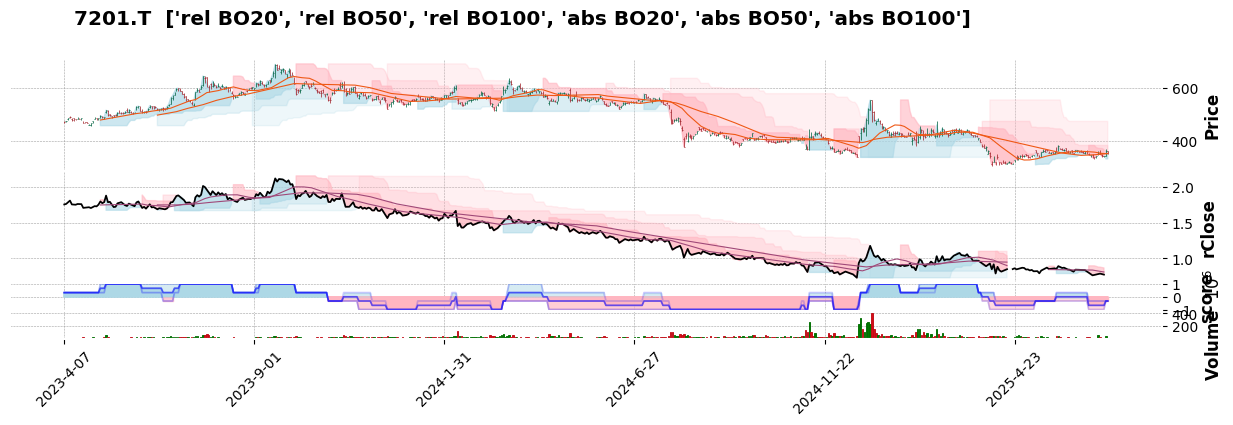

Price,rClose,rel BO20,rel BO50,rel BO100,abs BO20,abs BO50,abs BO100,score_abs,score_rel,score
Date,,,,,,,,,,
2025-07-02,0.775176,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.00,-0.33,-0.67
2025-07-03,NaN,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-0.33,-0.33,-0.33
2025-07-04,0.789289,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-0.33,-0.33,-0.33


In [9]:
fields_list = [] ; fields_list_rel = [] ; subplots = [] ; pane = 1
mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')    
    
    for t, slt in enumerate(sorted(bo_list)):
        bo_field = f'{col_name}BO{slt}'
        df[bo_field] = regime_breakout(df,_h,_l,slt)      
        
        _min = df[start_mpf:][_l].rolling(slt).min()
        _max = df[start_mpf:][_h].rolling(slt).max()
        mpf_fill(df[start_mpf:], _min, _max, color_bull, color_bear, alfa/(t+1), pane, field= bo_field)
        fields_list.append(bo_field)    
    if rel:
        fields_list_rel += fields_list        
    pane = 0
    
fields_list_abs = list(set(fields_list) - set(fields_list_rel))    
df['score_abs'] = round(df[fields_list_abs].mean(axis=1),2).values
df['score_rel'] = round(df[fields_list_rel].mean(axis=1),2).values
df['score'] = round(df[fields_list].mean(axis=1),2).values
mpf_score(df[start_mpf:], score_list, alfa, color_bull, color_bear, pane= 2, vlabel = 'score') 
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (16,4), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 3, panel_ratios = (2,2,0.5,0.5))  

df.iloc[-3:,-10:]

####    5.2. Turtle Trader

This script builds on the regime_breakout function. When the _lt does not match the _st, then go neutral

In [10]:
def turtle_trader(df, _h, _l, st, lt):
    '''
    _lt: Long/Short direction
    _st: trailing stop loss
    '''
    _lt = regime_breakout(df,_h,_l,lt)
    _st = regime_breakout(df,_h,_l,st)
    turtle = pd. Series(index= df.index, data = np.where(_lt == 1,np.where(_st == 1,1,0), 
                                                         np.where(_lt == -1, np.where(_st ==-1,-1,0),0)))
    return turtle

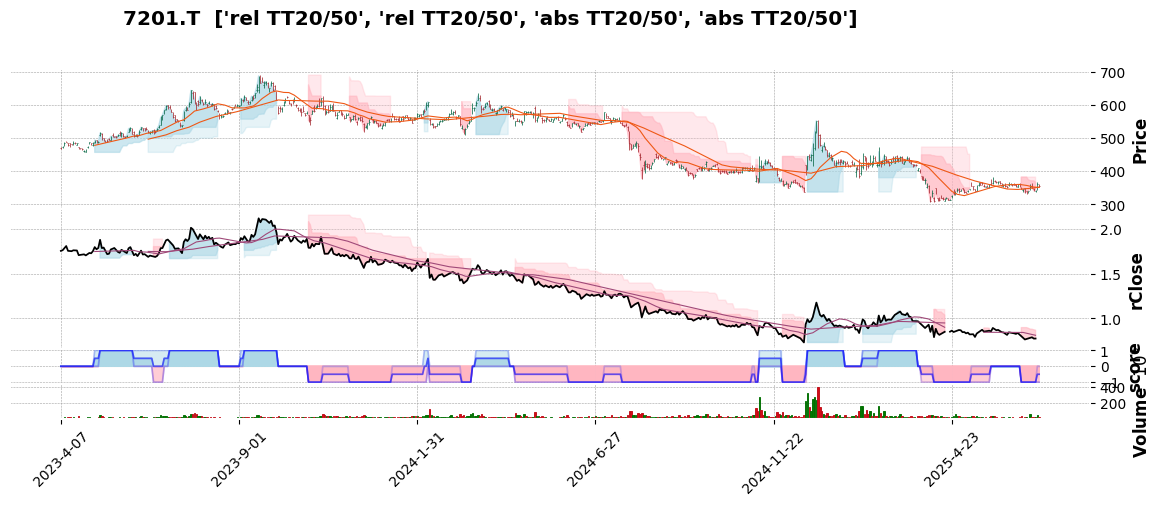

Price,rel BO50,rel BO100,abs BO20,abs BO50,abs BO100,score_abs,score_rel,score,rel TT20/50,abs TT20/50
Date,,,,,,,,,,
2025-07-02,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1
2025-07-03,-1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-0.5,-1,0
2025-07-04,-1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-0.5,-1,0


In [11]:
fields_list = [] ; fields_list_rel = [] ; subplots = [] ; pane = 1
mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')    
    
    for t, slt in enumerate(sorted(bo_list[:2])):
        tt_field = f'{col_name}TT{st}/{lt}'
        df[tt_field] = turtle_trader(df, _h, _l, st, lt)
        
        _min = df[start_mpf:][_l].rolling(slt).min()
        _max = df[start_mpf:][_h].rolling(slt).max()
        mpf_fill(df[start_mpf:], _min, _max, color_bull, color_bear, alfa/(t+1), pane, field= tt_field)
        fields_list.append(tt_field)    
    if rel:
        fields_list_rel += fields_list
    pane = 0
fields_list_abs = list(set(fields_list) - set(fields_list_rel))    
df['score_abs'] = round(df[fields_list_abs].mean(axis=1),2).values
df['score_rel'] = round(df[fields_list_rel].mean(axis=1),2).values
df['score'] = round(df[fields_list].mean(axis=1),2).values
mpf_score(df[start_mpf:], score_list, alfa, color_bull, color_bear, pane= 2, vlabel = 'score') 
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (15,5), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 3, panel_ratios = (2,2,0.5,0.5))  

df.iloc[-3:,-10:]

####    5.3. Moving Averages: SMA, EMA

Regime is the sign difference between the short-term and long-term moving averages.

In [12]:
def regime_sma(df,_c,st,lt):
    sma_lt = df[_c].rolling(lt).mean()
    sma_st = df[_c].rolling(st).mean()
    rg_sma = np.sign(sma_st - sma_lt)
    return rg_sma

def regime_ema(df,_c,st,lt):
    ema_st = df[_c].ewm(span=st,min_periods = st).mean()
    ema_lt = df[_c].ewm(span=lt,min_periods = lt).mean()
    rg_ema = np.sign(ema_st - ema_lt)
    return rg_ema

We recycle the mpf_fill function. Instead of calculating a minimum and maximum, we repeat the sma.

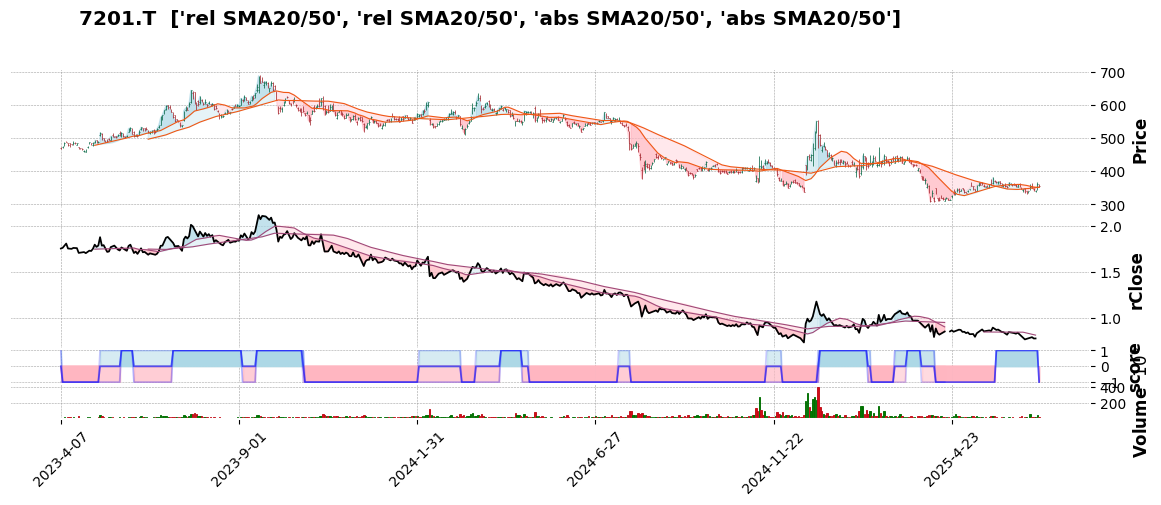

Price,abs BO100,score_abs,score_rel,score,rel TT20/50,abs TT20/50,rel SMA20/50,rel EMA20/50,abs SMA20/50,abs EMA20/50
Date,,,,,,,,,,
2025-07-02,-1.0,1.0,NaN,1.0,-1,-1,NaN,-1.0,1.0,-1.0
2025-07-03,-1.0,1.0,NaN,1.0,-1,0,NaN,-1.0,1.0,-1.0
2025-07-04,-1.0,-1.0,NaN,-1.0,-1,0,NaN,-1.0,-1.0,-1.0


In [13]:
fields_list = [] ; fields_list_rel = [] ; subplots = [] ; pane = 1
mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')        
        
    for t, slt in enumerate(sorted(sma_list)):
        sma_field = f'{col_name}SMA{st}/{lt}'
        df[sma_field] = regime_sma(df, _c,st,lt)
        ema_field = f'{col_name}EMA{st}/{lt}'
        df[ema_field] = regime_ema(df, _c,st,lt)
        
        sma = df[start_mpf:][_c].rolling(slt).mean()
        mpf_fill(df[start_mpf:], sma, sma, color_bull, color_bear, alfa/(t+1), pane, field= sma_field)
        fields_list.append(sma_field)     
    if rel:
        fields_list_rel += fields_list
    pane = 0
fields_list_abs = list(set(fields_list) - set(fields_list_rel))    
df['score_abs'] = round(df[fields_list_abs].mean(axis=1),2).values
df['score_rel'] = round(df[fields_list_rel].mean(axis=1),2).values
df['score'] = round(df[fields_list].mean(axis=1),2).values
mpf_score(df[start_mpf:], score_list, alfa, color_bull, color_bear, pane= 2, vlabel = 'score') 
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (15,5), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 3, panel_ratios = (2,2,0.5,0.5))  

df.iloc[-3:,-10:]

####    5.4. Fractals

def avg_px(df, _h, _l, _c): Calculates the average price using HLC bars

def fractal(px, lvl): This function identifies fractals at multiple levels

def fractals_df(df, col, col_name): This function calculates fractals swings Highs and Lows at multiple levels of abstraction

def fractals_dates(df, col, col_name): This function calculates the dates when fractals at each level are discovered


In [14]:

def avg_px(df, _h, _l, _c):
    return df[[_h,_l,_c]].mean(axis=1)

def fractal(px, lvl):
    max_lvl = np.minimum(2,lvl)
    fractal = px[(px<= px.shift(-1)) & (px < px.shift(+1)) &
                 (px<= px.shift(- max_lvl)) & (px < px.shift(+ max_lvl))]
    return fractal

def fractals_df(df, col, col_name): 
    ffill_list = []
    hilo = df[col].copy()

    n = 1
    temp_cols = {}  # Dictionary to store new columns
    while len(hilo) >= 3:
        lows = fractal(hilo, n)
        if not lows.empty:
            last_low = lows.iloc[-1:].copy()
        else:
            last_low = pd.Series()
            
        highs = -fractal(-hilo, n)
        if not highs.empty:
            last_high = highs.iloc[-1:].copy()
        else:
            last_high = pd.Series()            
        hilo = lows.add(highs, fill_value=0).dropna()

        level_low_col = f'{col_name}Lo{n}'
        level_high_col = f'{col_name}Hi{n}'
        hilo_col = f'{col_name}HiLo{n}'
        
        if (not lows.empty) and (not highs.empty):
            if (not last_low.empty) and (not last_high.empty) and (last_low.index[-1] > last_high.index[-1]):
                lows = pd.concat([fractal(hilo, 1), last_low])
                highs = -fractal(-hilo, 1)
            elif (not last_low.empty) and (not last_high.empty) and (last_low.index[-1] < last_high.index[-1]):
                lows = fractal(hilo, 1)
                highs = pd.concat([-fractal(-hilo, 1), last_high])
                
            hilo = lows.add(highs, fill_value=0).dropna()
            temp_cols[level_low_col] = lows
            temp_cols[level_high_col] = highs
            temp_cols[hilo_col] = hilo
            
        elif not lows.empty:
            temp_cols[level_low_col] = lows
            temp_cols[hilo_col] = lows
            
        elif not highs.empty:
            temp_cols[level_high_col] = highs
            temp_cols[hilo_col] = highs
            
        ffill_list.append(hilo_col)
        n += 1
        
        if hilo.empty:
            break
        
    # Concatenate all columns in temp_cols with df in one operation   
    if temp_cols:  # Check if temp_cols is not empty
        temp_df = pd.DataFrame(temp_cols)
        df = pd.concat([df, temp_df], axis=1)
        df.dropna(how='all', axis=1, inplace=True)
        df = df.loc[:, ~df.columns.duplicated(keep='last')]
        
        list_ffill = [col for col in ffill_list if col in df.columns]
        if list_ffill:  # propagate HiLo values forward
            df[list_ffill] = df[list_ffill].ffill()            
    return df

def fractals_dates(df, col, col_name):
    """
    Identifies when fractal patterns are discovered and records:
    1. The fractal value at discovery time (_fc)
    2. The price at the next data point (_chg)
    """    # Initialize a dictionary to hold temporary columns
    temp_cols_dict = {}
    for hl in ['Hi', 'Lo']:              
        if (hl == 'Lo'):
            high_cols_df  = pd.DataFrame.from_dict(temp_cols_dict)     
        hilos = df.copy()
        n = 1 ; s = 1                
        while f'{col_name}{hl}{n}' in hilos.columns:            
            hilos = hilos[ (pd.notnull(hilos[f'{col_name}{hl}{n}'])) | (pd.notnull(hilos[f'{col_name}{hl}{n}'].shift(s))) ]
            
            temp_cols_dict.update({f'{col_name}HiLo{n}_chg': hilos.loc[ (pd.isnull(hilos[f'{col_name}{hl}{n}'])), col],
                    f'{col_name}HiLo{n}_fc': hilos.loc[ (pd.isnull(hilos[f'{col_name}{hl}{n}'])), f'{col_name}HiLo{n}'] })      
            n +=1 ; s = 3

    low_cols_df = pd.DataFrame.from_dict(temp_cols_dict)         
    hilo_cols_df = high_cols_df.add(low_cols_df, fill_value =0)
    df = pd.concat([df, hilo_cols_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    df[hilo_cols_df.columns] = df[hilo_cols_df.columns].ffill()
    return df

fractals_df (2589, 41)
fractals_df (2589, 66)


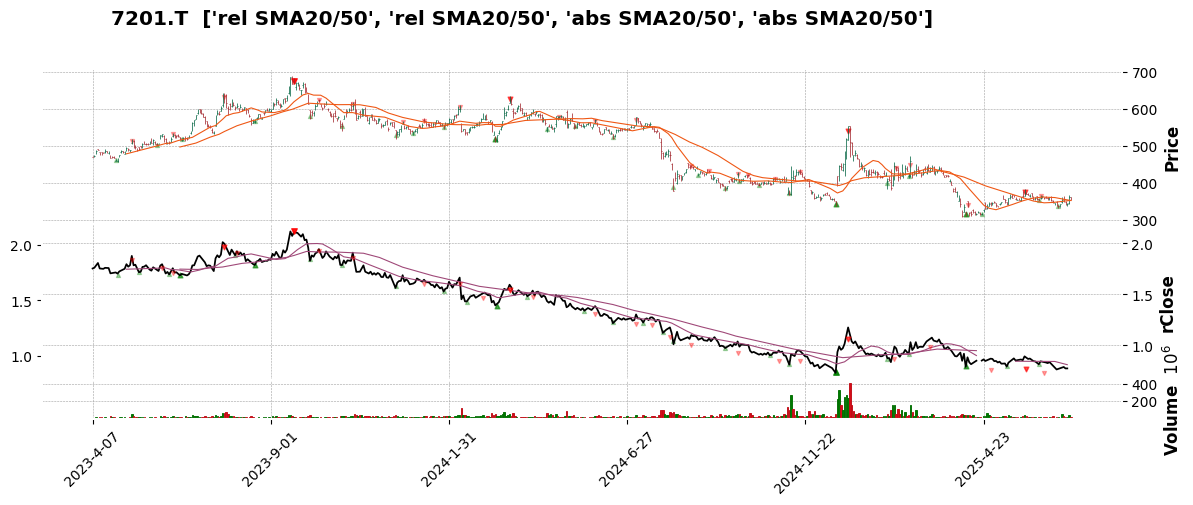

,abs HiLo1_chg,abs HiLo1_fc,abs HiLo2_chg,abs HiLo2_fc,abs HiLo3_chg,abs HiLo3_fc,abs HiLo4_chg,abs HiLo4_fc,abs HiLo5_chg,abs HiLo5_fc
Date,,,,,,,,,,
2025-07-02,343.666667,354.233333,356.166667,362.633333,356.166667,375.3,554.033333,674.526667,589.473333,300.733333
2025-07-03,357.233333,357.233333,357.233333,336.433333,356.166667,375.3,554.033333,674.526667,589.473333,300.733333
2025-07-04,356.133333,357.233333,357.233333,336.433333,356.166667,375.3,554.033333,674.526667,589.473333,300.733333


In [15]:
subplots = [] ; pane = 1
fractals_list = [2,3,4,5,6]

mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')    
    
    col = f'avg_{col_name}'
    df[col] = avg_px(df, _h, _l, _c)
    df = fractals_df(df, col, col_name)    
    print('fractals_df',df.shape)
    df = fractals_dates(df,col,col_name)  
    
    mpf_fractals(df[start_mpf:],col_name, fractals_list, color_up, color_down, size, pane)        
    pane = 0
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (15,5), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 2, panel_ratios = (2,2,0.5,))  

df.iloc[-3:,-10:]

<Axes: title={'center': '7201.T fractals 2'}, xlabel='Date'>

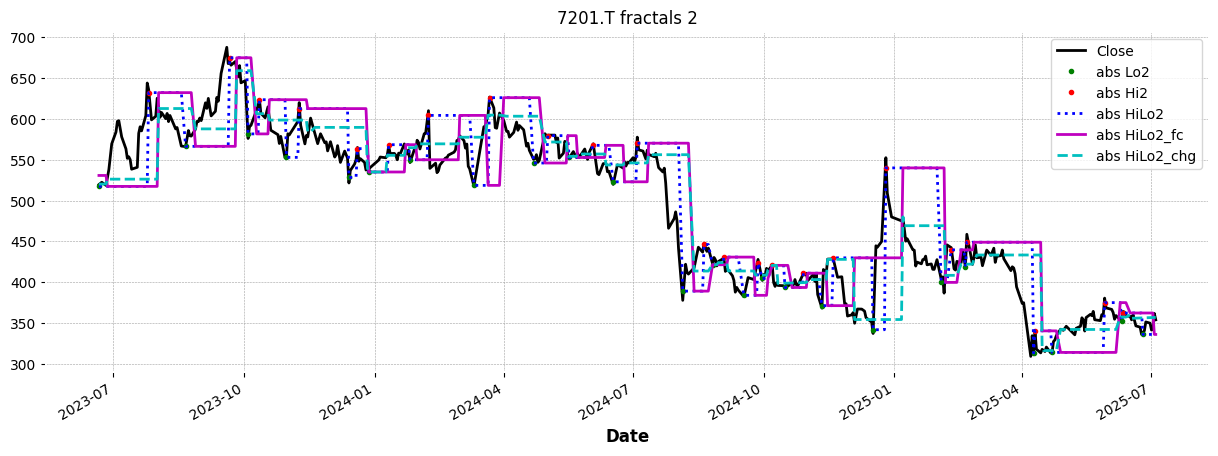

In [17]:
t = 2

df[-500:][['Close',f'abs Lo{t}', f'abs Hi{t}', f'abs HiLo{t}',f'abs HiLo{t}_fc', f'abs HiLo{t}_chg' ]].plot(figsize=(15,5), 
        style= ['k','g.','r.','b:','m','c--'], title = f'{ticker} fractals {t}', grid=True)

####    5.5. HigherHighs

1. Bullish: Higher highs, higher lows 
2. Bearish: Lower lows, lower highs
3. Regime reverts until condition on the other side are met, no stop loss

In [19]:

def higherhighs_df(df,_c,col_name,shft= 2):
    v = 1
    while (f'{col_name}Lo{v}' in df.columns) & (f'{col_name}Hi{v}' in df.columns):        
        lh = pd.DataFrame()
        hl = f'{col_name}HiLo{v}_hl'
        lhv = f'{col_name}LoHi{v}'
        lh[lhv] = df[f'{col_name}Lo{v}'].sub(df[f'{col_name}Hi{v}'],fill_value =0).dropna()
        lh.loc[(np.sign(lh[lhv]) < 0) & 
            (np.sign(lh[lhv] * lh[lhv].shift()) < 0) & 
            (-lh[lhv] < -lh[lhv].shift(2)) & 
            (lh[lhv].shift(1) < lh[lhv].shift(3)), hl] = -lh[lhv].shift(shft)
        
        lh.loc[(np.sign(lh[lhv])>0) & 
            (np.sign(lh[lhv] * lh[lhv].shift()) < 0) & 
            (lh[lhv] > lh[lhv].shift(2)) & 
            (-lh[lhv].shift(1) > -lh[lhv].shift(3)), hl] = lh[lhv].shift(shft)
        lh = lh.dropna(subset = [hl])
        
        df[hl] = lh[hl]
        df[hl] = df[hl].ffill()
        df[ f'{col_name}HiLo_HH{v}' ] = np.sign(df[_c].sub(df[hl],fill_value=0))
        v += 1
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    return df

we create a weighted average df[f'{col_name}HiLo_HH'] to fill colours

fractals_df (2589, 76)
fractals_df (2589, 85)


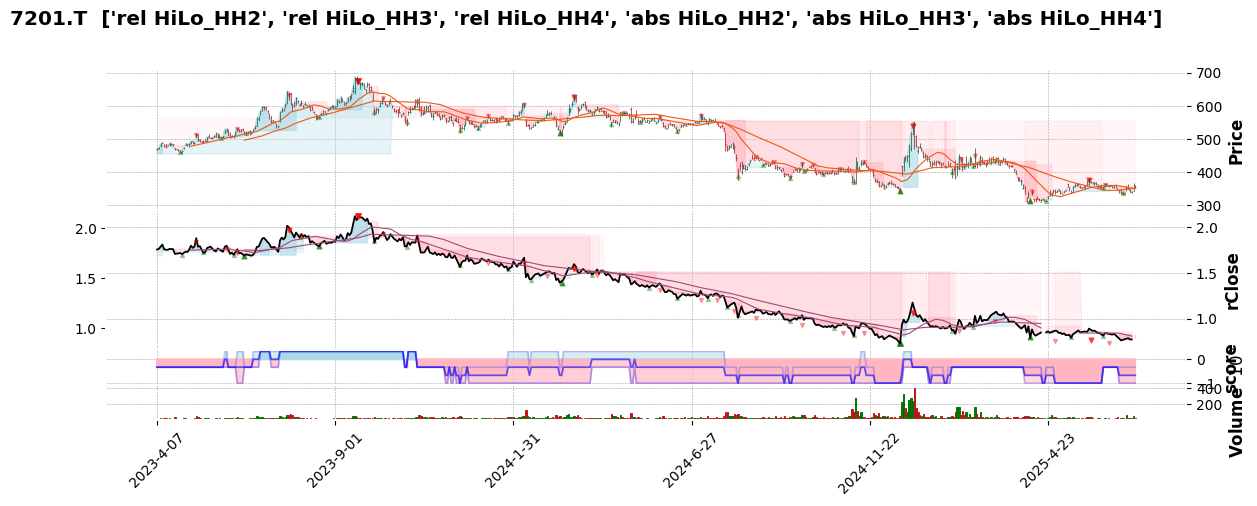

,abs HiLo5_fc,abs HiLo1_hl,abs HiLo_HH1,abs HiLo2_hl,abs HiLo_HH2,abs HiLo3_hl,abs HiLo_HH3,abs HiLo4_hl,abs HiLo_HH4,abs HiLo_HH
Date,,,,,,,,,,
2025-07-02,300.733333,357.8,-1.0,314.466667,1.0,539.933333,-1.0,1018.343333,-1.0,2.775558e-17
2025-07-03,300.733333,357.8,1.0,314.466667,1.0,539.933333,-1.0,1018.343333,-1.0,2.775558e-17
2025-07-04,300.733333,357.8,-1.0,314.466667,1.0,539.933333,-1.0,1018.343333,-1.0,2.775558e-17


In [20]:
fields_list = [] ; fields_list_rel = [] ; subplots = [] ; pane = 1
fractals_list = [2,3,4,5,6]

mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')    
    
    col = f'avg_{col_name}'
    df[col] = avg_px(df, _h, _l, _c)
    df = fractals_df(df, col, col_name)    
    print('fractals_df',df.shape)
    df = fractals_dates(df,col,col_name) 
    df = higherhighs_df(df,_c,col_name,shft= 2)
    df[f'{col_name}HiLo_HH'] = df[f'{col_name}HiLo_HH2'] * 0.4 + df[f'{col_name}HiLo_HH3'] * 0.3 + df[f'{col_name}HiLo_HH4'] * 0.1    
        
    for t, slt in enumerate(sorted(fractals_list)):
        if f'{col_name}HiLo_HH{slt}' in df.columns:          
            fc_values = df[start_mpf:][f'{col_name}HiLo{slt}_chg']
            mpf_fill(df[start_mpf:], fc_values, fc_values, color_bull, color_bear, alfa/(t+1), pane, field=f'{col_name}HiLo_HH')
            fields_list.append(f'{col_name}HiLo_HH{slt}')
    mpf_fractals(df[start_mpf:],col_name, fractals_list, color_up, color_down, size, pane)       
    if rel:
        fields_list_rel += fields_list
    
    pane = 0
fields_list_abs = list(set(fields_list) - set(fields_list_rel))    
df['score_abs'] = round(df[fields_list_abs].mean(axis=1),2).values
df['score_rel'] = round(df[fields_list_rel].mean(axis=1),2).values
df['score'] = round(df[fields_list].mean(axis=1),2).values
mpf_score(df[start_mpf:], score_list, alfa, color_bull, color_bear, pane= 2, vlabel = 'score') 
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (15,5), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 3, panel_ratios = (2,2,0.5,0.5))  

df.iloc[-3:,-10:]

####    5.6. Floor & Ceiling

1.	Bearish: A swing high must be lower than the peak.
2.	Bullish: A swing low must be higher than the bottom.

This function has three levels of calculation:

1.	Columns with the suffix _chg' show the price at the time the fractal was discovered. 
2.	If the suffix _chg' is not present the regime will be the sign difference between the fractal value and the current ‘Close’ price. 
3.	Finally, when none of those suffixes are present, the regime will be the production default: sign difference between price and fractal price. 

In [21]:

def floorceiling_df(df,_c,col_name):
    '''
    Regime is the sign difference between the close price and the base price. 
    It can be the floor/ceiling price or the average price at the time the fractal discovered later.
    1. _fc (default when '_fc' is in the df.columns): Floor/Ceiling price at the time the Floor/Ceiling is discovered later (Built-in lag)
    2. _chg: Average price at the time the fractal is discovered later (Built-in lag). Write 'chg' in the setting of the function to use this condition
    3. else: Floor/Ceiling price at the time of the floor/ceiling fractal. If none of the above conditions are met, 
            the default is the floor/ceiling price at the time of the fractal
    '''
    rg_FC_dict = {}
    v= 2
    while f'{col_name}HiLo{v}' in df.columns:   
                 
        if (f'{col_name}HiLo{v}_chg' in df.columns):
            rg_FC_dict[f'{col_name}HiLo_FC{v}'] = np.sign(df[_c].rolling(2).mean().sub(
                df[f'{col_name}HiLo{v}_chg'],fill_value = 0))   
        
        elif (f'{col_name}HiLo{v}_fc' in df.columns):  
            rg_FC_dict[f'{col_name}HiLo_FC{v}'] = np.sign(df[_c].rolling(2).mean().sub(
                df[f'{col_name}HiLo{v}_fc'],fill_value = 0))   
            
        else:
            rg_FC_dict[f'{col_name}HiLo_FC{v}'] = np.sign(df[_c].rolling(2).mean().sub(
                                                                    df[f'{col_name}HiLo{v}'], fill_value = 0))                    
        v+=1
        
    df = pd.concat([df,pd.DataFrame(rg_FC_dict)], axis =1)
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    return df

fractals_df (2589, 94)
fractals_df (2589, 99)


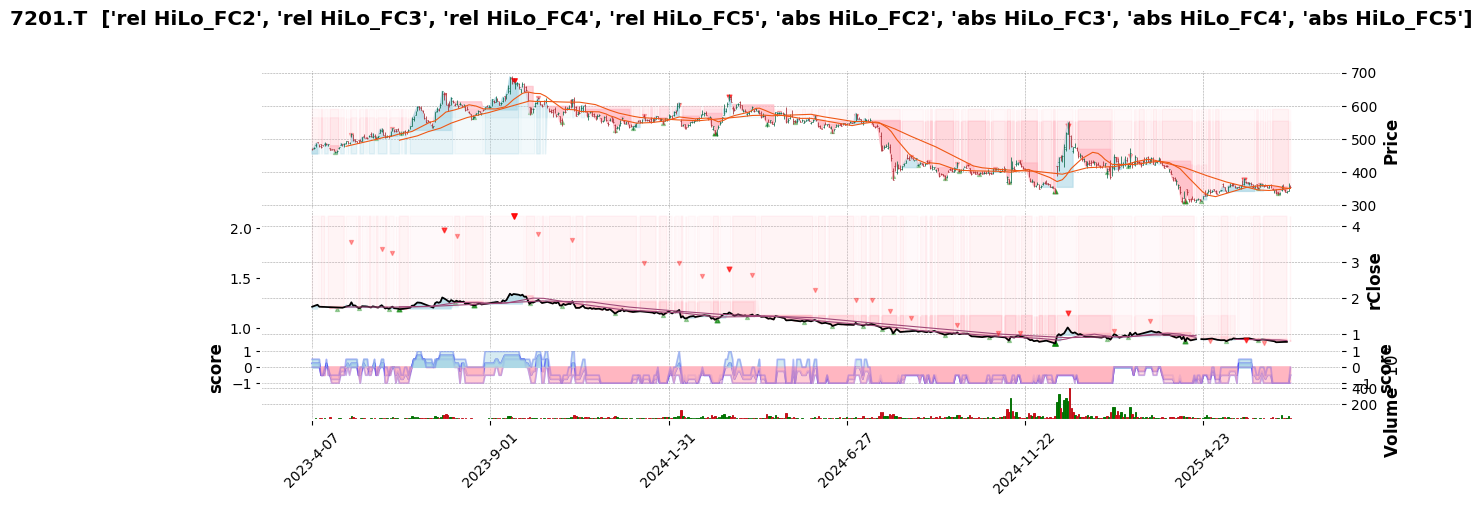

,abs HiLo3_fc,abs HiLo4_chg,abs HiLo4_fc,abs HiLo5_chg,abs HiLo5_fc,abs HiLo_FC2,abs HiLo_FC3,abs HiLo_FC4,abs HiLo_FC5,abs HiLo_FC
Date,,,,,,,,,,
2025-07-02,375.3,554.033333,674.526667,589.473333,300.733333,-1.0,-1.0,-1.0,-1.0,-0.8
2025-07-03,375.3,554.033333,674.526667,589.473333,300.733333,-1.0,-1.0,-1.0,-1.0,-0.8
2025-07-04,375.3,554.033333,674.526667,589.473333,300.733333,1.0,1.0,-1.0,-1.0,0.6


In [22]:
fields_list = [] ; fields_list_rel = [] ; subplots = [] ; pane = 1
fractals_list = [2,3,4,5,6]

mpf_relative(df[start_mpf:], rel=True, sma_list= sma_list, pane=1, color= 'k')
for rel in rel_list:
    _o,_h,_l,_c = rohlc(df,rel)      
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')    
    
    col = f'avg_{col_name}'
    df[col] = avg_px(df, _h, _l, _c)
    df = fractals_df(df, col, col_name)    
    print('fractals_df',df.shape)
    df = fractals_dates(df,col,col_name) 
    df = floorceiling_df(df,_c,col_name)
    df[f'{col_name}HiLo_FC'] = df[f'{col_name}HiLo_FC2'] * 0.4 + df[f'{col_name}HiLo_FC3'] * 0.3 + df[f'{col_name}HiLo_FC4'] * 0.1
    
    mpf_fractals(df[start_mpf:],col_name, fractals_list, color_up, color_down, size, pane)        
    for t, slt in enumerate(sorted(fractals_list)):
        if f'{col_name}HiLo_FC{slt}' in df.columns:          
            fc_values = df[start_mpf:][f'{col_name}HiLo{slt}_chg']
            mpf_fill(df[start_mpf:], fc_values, fc_values, color_bull, color_bear, alfa/(t+1), pane, field=f'{col_name}HiLo_FC')
            fields_list.append(f'{col_name}HiLo_FC{slt}')    
    if rel:
        fields_list_rel += fields_list    
    pane = 0
fields_list_abs = list(set(fields_list) - set(fields_list_rel))    
df['score_abs'] = round(df[fields_list_abs].mean(axis=1),2).values
df['score_rel'] = round(df[fields_list_rel].mean(axis=1),2).values
df['score'] = round(df[fields_list].mean(axis=1),2).values
mpf_score(df[start_mpf:], score_list, alfa, color_bull, color_bear, pane= 2, vlabel = 'score') 
mpf.plot(df[start_mpf:], type= 'ohlc', style= 'charles', figsize= (15,5), title =  f'{ticker}  {fields_list}', mav = tuple(sorted(sma_list)),
             addplot= subplots, volume= True, volume_panel = 3, panel_ratios = (2,2,0.5,0.5))  

df.iloc[-3:,-10:]

####    5.7. Score

def dict_fractal(col_name, rg_method, fractal_dict): is a dictionary comprehension. We blend the col name, the regime method and the fractal level with their corresponding weight.

def rg_dict_blend(df, rg_dict): This function calculates the weighted average of regime dictionary. 

1. We will create a dictionary of regime methods and their corresponding weights
2. We then create a score for the absolute series and for the relative series
3. We then concatenate the two dictionaries absolute and relative into a composite score
4. We plot the absolute, relative and overall scores along with the ‘Close’ price for the entire duration of the data frame

True, False, 

[True, False]

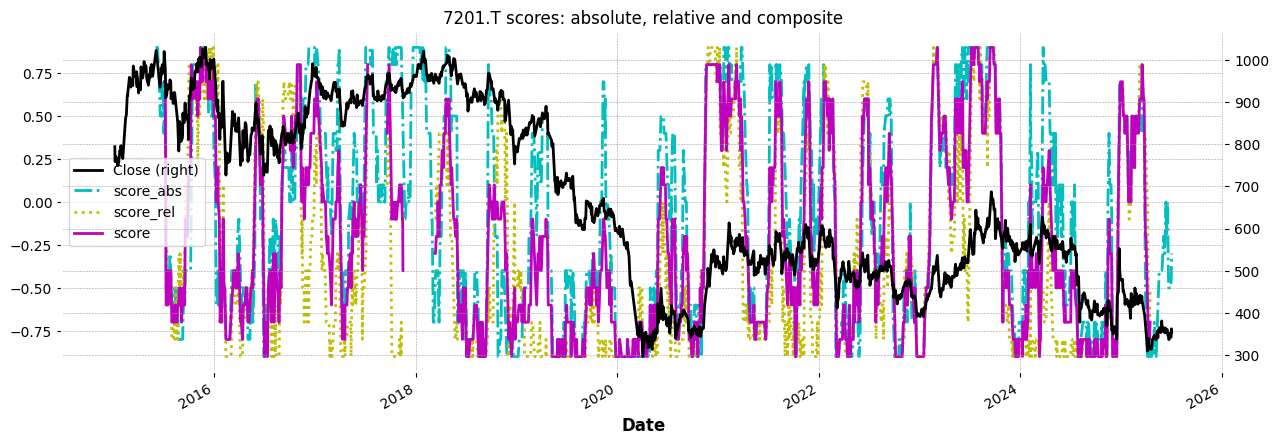

In [23]:

def dict_fractal(col_name, rg_method, fractal_dict):
    '''
    col_name: 'abs ' or 'rel '
    rg_method: 'HiLo_FC' or 'HiLo_HH'
    fractal_dict: for example {1: 0.1,2:0.4, 3:0.3, 4:0.2}
    '''
    return {f'{col_name}{rg_method}{v}':fractal_dict[v] for v in fractal_dict}

def rg_dict_blend(df, rg_dict):
    blend = np.zeros(len(df))
    n = 0
    for rg in rg_dict:
        if rg in df.columns:
            if rg_dict[rg] > 0:
                blend += df[rg] * rg_dict[rg]
                n += rg_dict[rg]
            else:
                blend += df[rg] 
                n += 1
    return round(blend / max(n,1),1)

for rel in rel_list:
    print(rel, end = ', ')
    _o,_h,_l,_c = rohlc(df,rel)  
    col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')
    rg_cols_dict = {f'{col_name}BO{st}':0.1, f'{col_name}BO{lt}':0.2, f'{col_name}BO{xlt}':0.1,
                f'{col_name}TT{st}/{lt}':0.2,
                f'{col_name}SMA{st}/{lt}':0.2, 
                f'{col_name}EMA{st}/{lt}': 0.2,
                f'{col_name}HiLo_HH':0.25,f'{col_name}HiLo_FC':0.25}
    if rel == False:
        score_abs_dict = rg_cols_dict
    elif rel == True:
        score_rel_dict = rg_cols_dict
score_dict = {**score_abs_dict, **score_rel_dict}

df['score_abs'] = rg_dict_blend(df, score_abs_dict)
df['score_rel'] = rg_dict_blend(df, score_rel_dict) 
df['score'] = rg_dict_blend(df, score_dict)
df[['Close', 'score_abs', 'score_rel', 'score']].plot(figsize=(15,5), style = ['k', 'c-.', 'y:', 'm'], 
                                                      secondary_y = 'Close',grid=True, title = f'{ticker} scores: absolute, relative and composite')

len(score_dict), score_dict
rel_list

## 6. Set-up & Initialise arcticDB

def initialise_adb_library_local(uri_path, library_name): arcticDB need to be initialised. This function either creates a DB or initialises it. The uri_path default will be a folder on top of the current working directory

def adb_concat_single_column(library, symbols, column_name): creates a df from a single field across a list of symbols

def adb_concat_multiple_fields(library, symbols, column_names): creates a df from multiple fields across a list of symbols


In [24]:
def initialise_adb_library_local(uri_path, library_name):
    uri = f"lmdb://{uri_path}" # this will set up the storage using the local file system
    ac = adb.Arctic(uri)
    library = ac.get_library(library_name, create_if_missing=True,)# library_options=LibraryOptions(dynamic_schema=True))
    return library

def adb_concat_single_column(library, symbols, column_name):
    symbols_list = [symbol for symbol in symbols if symbol in library.list_symbols()]
    comp_list_from_adb = [library.read(symbol, columns=[column_name]).data.rename(columns={column_name: symbol}) for symbol in symbols_list]
    return pd.concat(comp_list_from_adb, axis=1)

In [25]:
library = initialise_adb_library_local('data', 'autos')


## 7. Data manipulation across the investment universe

1. Loop through the tickers_list 
2. Droplevel to get single ticker OHLCV, calculate currency adjusted relative series for each security
3. Loop through rel;_list [True, False], calculate regime for abs and relative
4. Calculate score absolute, relative composite
5. append last_row_list by last_row_dict
6. write arcticDB 
7. update df_dict({ticker, df.copy()})
8. create mmultiindex_df from df_dict

In [26]:
def multiindex_from_dict(df_dict, yf_format=False):
    multi_df = pd.concat(df_dict, axis=1)
    multi_df = multi_df.reindex(multi_df.columns, axis=1)
    if yf_format:
        multi_df.columns = multi_df.columns.reorder_levels([1, 0])
    return multi_df

In [27]:
fractal_dict = {1: 0.1,2:0.4, 3:0.3, 4:0.2}
df_dict = {} ; last_row_list= []

for ticker in tickers_list:
    raw_df = yf_droplevel(multiIndex_raw_data,ticker)
    _o,_h,_l,_c = rohlc(raw_df,relative = False)  
    df = rel_fx(raw_df,_o,_h,_l,_c, bm_df, bm, ccy_df, tickers_fx_dict[ticker], start, end,rebase=True, mult=1)
    print(ticker, df.shape, end =',')
    
    for rel in rel_list:
        _o,_h,_l,_c = rohlc(df,rel)  
        col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')
        for slt in sorted(bo_list): 
            df[f'{col_name}BO{slt}'] = regime_breakout(df,_h,_l,slt) 
        df[f'{col_name}TT{st}/{lt}'] = turtle_trader(df, _h, _l, st, lt)    
        df[f'{col_name}SMA{st}/{lt}'] = regime_sma(df, _c, st, lt)
        df[f'{col_name}EMA{st}/{lt}'] = regime_ema(df, _c, st, lt)                        
                        
        col = f'avg_{col_name}'
        df[col] = avg_px(df, _h, _l, _c)
        df = fractals_df(df, col, col_name)  
        df = fractals_dates(df,col,col_name)        
        df = floorceiling_df(df,_c,col_name)
        df[f'{col_name}HiLo_FC'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_FC', fractal_dict))
        df = higherhighs_df(df,_c,col_name,shft= 2)
        df[f'{col_name}HiLo_HH'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_HH', fractal_dict)) 
               
    df['score_abs'] = rg_dict_blend(df, score_abs_dict)
    df['score_rel'] = rg_dict_blend(df, score_rel_dict)
    df['score'] = rg_dict_blend(df, score_dict)
    df = round(df,2)
    library.write(ticker, df)
    
    last_row_list.append(last_row_cols_dict(df,ticker,df.columns))
        
    print( df.shape)
    df_dict.update({ticker: df.copy()})
    
multiIndex_df = multiindex_from_dict(df_dict, yf_format=False).round(2)
multiIndex_df.iloc[-3:,-20:]

7203.T (2589, 11),(2589, 104)
7201.T (2589, 11),(2589, 104)
1211.HK (2586, 11),(2586, 104)
005380.KS (2577, 11),(2577, 107)
VOW3.DE (2671, 11),(2671, 99)
RNO.PA (2690, 11),(2690, 104)
F (2641, 11),(2641, 107)
TSLA (2641, 11),(2641, 107)
GM (2641, 11),(2641, 104)


GM                                                       \
           abs HiLo4_fc abs HiLo5_chg abs HiLo5_fc abs HiLo_FC2 abs HiLo_FC3   
Date                                                                           
2025-07-02        59.63         64.37       125.15          1.0          1.0   
2025-07-03        59.63         64.37       125.15          1.0          1.0   
2025-07-04          NaN           NaN          NaN          NaN          NaN   

                                                                            \
           abs HiLo_FC4 abs HiLo_FC5 abs HiLo_FC abs HiLo1_hl abs HiLo_HH1   
Date                                                                         
2025-07-02          1.0         -1.0         0.9        48.35          1.0   
2025-07-03          1.0         -1.0         0.9        48.35          1.0   
2025-07-04          NaN          NaN         NaN          NaN          NaN   

                                                                             \
           abs HiLo2_hl abs HiLo_HH2 abs HiLo3_hl abs HiLo_HH3 abs HiLo4_hl   
Date                                                                          
2025-07-02        44.14          1.0        39.32          1.0        16.21   
2025-07-03        44.14          1.0        39.32          1.0        16.21   
2025-07-04          NaN          NaN          NaN          NaN          NaN   

                                                               
           abs HiLo_HH4 abs HiLo_HH score_abs score_rel score  
Date                                                           
2025-07-02          1.0         1.0       0.8       0.1   0.5  
2025-07-03          1.0         1.0       1.0       NaN   NaN  
2025-07-04          NaN         NaN       NaN       NaN   NaN

#### 7.1 Snapshot of score across the investment universe

In [ ]:
last_row_df = pd.DataFrame(last_row_list).set_index('ticker')
display_cols = ['date','score', 'score_rel', 'score_abs'] + list(score_dict.keys())
score_sorted = last_row_df[display_cols].sort_values(by=['score'], ascending= True)


 
#### 7.2 Top 3, bottom 3

In [ ]:
pd.concat([score_sorted.head(3), score_sorted.tail(3)], axis=0)

#### 7.3 Data manipulation S&P 500 score absolute and relative

1. df_SP500: download the S&P 500 constituents from wikipedia
2. Download historical prices for S&P 500 constitutents
3. Initialise library_SP500
3. 

In [ ]:
df_SP500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
df_SP500 = df_SP500.rename(columns={'Symbol':'ticker', 'Security': 'name', 'GICS Sector':'sector','GICS Sub-Industry':'sub-industry'})
df_SP500['ticker'] = df_SP500['ticker'].str.replace('.', '-', regex =False)
df_SP500 = df_SP500.sort_values(by = ['sector','name']).set_index('ticker')

bm_ticker = '^GSPC'   ;  bm = 'SP500' ; ccy = 'local' ; dgt = 2
df_SP500.groupby('sector').count()

Download Historical prices for the S&P 500 constituents

In [ ]:
tickers_list = [bm_ticker] + list(df_SP500.index)[:] 

multiIndex_raw_data_SP500 = batch_df(tickers_list,batch_size, start, end,show_batch = False).round(2)
multiIndex_raw_data_SP500.shape

Initialise arcticDB 

In [ ]:
library_SP500 = initialise_adb_library_local('data', 'SP500')

Process data

In [ ]:
fractal_dict = {1: 0.1,2:0.4, 3:0.3, 4:0.2}
bm_ticker = '^GSPC'   ;  bm = 'SP500' ; ccy = 'local' ; dgt = 2
df_dict_SP500 = {} ; last_row_list_SP500 = []

for ticker in tickers_list:
    raw_df = yf_droplevel(multiIndex_raw_data_SP500,ticker)
    _o,_h,_l,_c = rohlc(raw_df,relative = False)  
    df = rel_fx(raw_df,_o,_h,_l,_c, bm_df, bm, ccy_df, ccy, start, end,rebase=True, mult=1)
    
    for rel in rel_list:
        _o,_h,_l,_c = rohlc(df,rel)  
        col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')
        for slt in sorted(bo_list): 
            df[f'{col_name}BO{slt}'] = regime_breakout(df,_h,_l,slt) 
        df[f'{col_name}TT{st}/{lt}'] = turtle_trader(df, _h, _l, st, lt)    
        df[f'{col_name}SMA{st}/{lt}'] = regime_sma(df, _c, st, lt)
        df[f'{col_name}EMA{st}/{lt}'] = regime_ema(df, _c, st, lt)                        
                        
        col = f'avg_{col_name}'
        df[col] = avg_px(df, _h, _l, _c)
        df = fractals_df(df, col, col_name)  
        df = fractals_dates(df,col,col_name)        
        df = floorceiling_df(df,_c,col_name)
        df[f'{col_name}HiLo_FC'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_FC', fractal_dict))
        df = higherhighs_df(df,_c,col_name,shft= 2)
        df[f'{col_name}HiLo_HH'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_HH', fractal_dict)) 
               
    df['score_abs'] = rg_dict_blend(df, score_abs_dict)#.ffill()
    df['score_rel'] = rg_dict_blend(df, score_rel_dict)#.ffill()
    df['score'] = rg_dict_blend(df, score_dict)#.ffill()
    df = round(df,2)
    library_SP500.write(ticker, df)
    
    last_row_list_SP500.append(last_row_cols_dict(df,ticker,df.columns))       
    df_dict_SP500.update({ticker: df.copy()})
    
multiIndex_df_SP500 = multiindex_from_dict(df_dict_SP500, yf_format=False).round(2)
multiIndex_df_SP500.iloc[-3:,-20:]

In [ ]:

sector_avg_score_rel  = pd.DataFrame()
score_SP500_rel = adb_concat_single_column(library_SP500, tickers_list, 'score_rel')
sector_avg_score_rel = bm_df[[bm]].join(sector_avg_df(df_SP500, 'sector', score_SP500_rel),how ='inner')
sector_avg_score_rel.plot(figsize=(15,8),secondary_y=[bm], style = ['k'])

## 8. Fractals in Production

We simulate continuous price update by slicing data and incrementing by one bar. Recalculate score, compare with previous value

1. instantiate last_row_list as a container for the snapshots
2. Slice data and increment by 1 period until data full legnth
3. snapshot of the last row appended: last_row_list.append(last_row_cols_dict(df,ticker,df_cols = list(df.columns)))
4. create a continuous_df from last_row_list

In [ ]:
ticker = '7201.T'
_columns = list(df.columns[:11]) + ['avg_abs ', 'avg_rel ']
data = library.read(ticker, columns=_columns, as_of=0).data

fractal_dict = {1: 0.1,2:0.2, 3:0.3, 4:0.2}
last_row_list = []

n = len(data) + start_mpf
while n <= len(data):
    df = data.iloc[:n,].copy()
    for rel in rel_list:
        _o,_h,_l,_c = rohlc(df,rel)      
        col_name = col_name_abs_rel(rel, name_abs = 'abs ', name_rel = 'rel ')  
        col = f'avg_{col_name}'        
        
        df = fractals_df(df, col, col_name)  
        df = floorceiling_df(df,_c,col_name)
        df[f'{col_name}HiLo_FC'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_FC', fractal_dict))
        df = higherhighs_df(df,_c,col_name,shft= 2)
        df[f'{col_name}HiLo_HH'] = rg_dict_blend(df,dict_fractal(col_name, 'HiLo_HH', fractal_dict))
        
    last_row_list.append(last_row_cols_dict(df,ticker,df_cols = list(df.columns)))
    n += 1

continuous_df = pd.DataFrame.from_dict(last_row_list).set_index('date').round(2)

8.1  avg price, Lo, Hi, higher highs and floor & Ceiling for absolute an drelative series

In [ ]:
continuous_df[['avg_abs ', 'abs Lo3','abs Hi3', 'abs HiLo_HH', 'abs HiLo_FC',]].plot(figsize=(15,4), 
            style = ['k', 'g-', 'r-','c:','y:', 'g','r',], 
            secondary_y = ['abs HiLo_HH', 'abs HiLo_FC'],
            grid=True, title = f'{ticker}  continuous last row absolute level 3')
             
continuous_df[['avg_rel ', 'rel Lo2','rel Hi2', 'rel HiLo_HH', 'rel HiLo_FC',]].plot(figsize=(15,4), 
            style = ['k', 'g-', 'r-','c:','y:', 'g','r',], 
            secondary_y = ['rel HiLo_HH', 'rel HiLo_FC'],
            grid=True, title = f'{ticker} continuous last row relative level 2')
             
continuous_df[['avg_rel ',
             'rel Lo3','rel Hi3', 'rel HiLo_HH',             'rel HiLo_FC',
             ]].plot(figsize=(15,5), 
            style = ['k', 'g-.', 'r-.','c:','y:', 'g','r',], 
            secondary_y = ['rel HiLo_HH', 'rel HiLo_FC'],
            grid=True, title = f'{ticker} last row')

## 9. Searching for the bar that triggered the bear market

#### 9.1 Build a gigantic df by concatenating 1 minute data

My dream has always been to develop a methodology that would be congruent across asset classes, timeframes without having to adjust parameters. Let's see if the fractals methodology to calcualte Floor & Ceiling as well as Higher High Higher Low fits the bill.

1. One Minute OHLCV data
Shout out to 'https://oneminutedata.com'. In the next section, we want to calculate fractals and regime at various time intervals. 

We have copied the link from the website and built a list. The address may periodicially change. SO, let's spend a few minutes building the dataframe

1. go to 'https://oneminutedata.com/spy-intraday-data'  
2. right click on Download Link, 'Copy Link Address'
3. Paste link in list
4. Loop through list using read_csv(index_col=0, parse_dates= True,compression = 'gzip'). Data is compressed using gzip, parse dates
5. Concatenate


In [ ]:

one_minute_weblinks = [ # Website source data: 'https://oneminutedata.com/spy-intraday-data' 
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2024_6e0851922b721890a49c6a240c230ba39670d1a7.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2023_703d78ef9b61798e6de7dd6bf8d8a668d51e5aaa.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2022_b0cb458763c66c311a46aa1f8b8549ded4e9da6f.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2021_b65d518b0047dd8eaa2c2c3a98c6f61ea8637569.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2020_cdb851e720986036f80db3aeeb5943e11490f10f.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2019_82b12186b367ab8006e0bf6c51c61f61a471e7ff.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2018_8347579bc522cc3617ace45ff3f81dc0df5a04d7.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2017_28c365f5e53b09b163ca8f36d62d82ae434ca538.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2016_c39e8ddcd9bced3a283b987d1ef91048ccfbe6bd.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2015_736c7bd2f88a7bdcd476fbdf0dedfd66b8c217a2.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2014_a8e5ee2292b7ebd074baf6720412476ecc19c441.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2013_e8bb4ae219ec14fcbe73ff011b6c537ba0b25fd7.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2012_a89a832898914f255e370b16908f536ff851538f.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2011_e63fe48d566afde3820631656e6cf2b313a71e00.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2010_16cd469f7011689f465dc50e13a6076853745de6.csv.gz',
                       'https://indigo-gazelle-447398.hostingersite.com/data/spy/spy_2009_3aa7d5c5434c69cb4ad89073c9cfe5a22db2713f.csv.gz',]
                       
historical_df_1min = pd.DataFrame()

for weblink in one_minute_weblinks:
    df = pd.read_csv(weblink, index_col=0, parse_dates= True,compression = 'gzip')
    historical_df_1min = pd.concat([historical_df_1min, df], axis =0)
    print(df['close'][-1:])

historical_df_1min.shape

#### 9.2 Resample data

we now have data down to the one minute bar level. Let's resample all the way up to weekly and process each level

1. We create a dictionary to index dataframes
2. We create a list of periods from '1min' to '1w'
3. We loop through the interval_list to populate the dictionary of resampled dataframes
4. We calculate regimes for each period
5. If you feel like saving data flag True 
6. Print shape of each dataframe

In [ ]:
def resample_ohlcv(df, rel, period ):
    _o,_h,_l,_c = rohlc(df,relative = rel) 
    ohlcv_dict = {_o: 'first',_h: 'max',_l:'min',_c: 'last','volume': 'sum'}
    intraday_dict = {dct : 'mean' for dct in df.columns[5:]}
    ohlcv_dict.update(intraday_dict)
    df_resampled = df.resample(period, closed='left', label='right').apply(ohlcv_dict)
    df_resampled = df_resampled.dropna(subset = [_o,_h,_l,_c])
    return df_resampled


#### 9.3 Resample and calculate regime at various intervals

1.	We instantiate the usual variables _o, _h, _l, _c, rel
2.	We create a fractal dictionary and increase the weight by 0.1 for every level. The objective is not to get a precise weight, just assign values
3.	We instantiate a df_dict that will contain all the dataframes
4.	We create an interval list
5.	We loop through the interval_list
6.	We process fractals and regime and populate the df_dict


In [ ]:
rel = False ; _o,_h,_l,_c = rohlc(df,rel)  ;    col_name= '' ;  col = f'avg'

rg_dict = {t : round(t*0.1,1) for t  in range(1,16)}
df_dict = {}
interval_list= ['1min','2min','3min','4min','5min','10min','15min','20min','30min','1h','4h','1d','1W']

df_1min = historical_df_1min.copy()
for interval in interval_list:
    if interval != '1min':        
        df_dict[interval]= resample_ohlcv(df_1min, rel= False, period = interval)
    else :
        df_dict[interval]= df_1min.copy()
    print(interval, df_dict[interval].shape, end = " ")
    
    df_dict[interval][col] = avg_px(df_dict[interval], _h, _l, _c)
    df_dict[interval] = fractals_df(df_dict[interval], col, col_name)  
    df_dict[interval] = fractals_dates(df_dict[interval],col,col_name)        
    df_dict[interval] = floorceiling_df(df_dict[interval],_c,col_name)
    df_dict[interval][f'{col_name}HiLo_FC'] = rg_dict_blend(df_dict[interval],dict_fractal(col_name, 'HiLo_FC', fractal_dict))
    df_dict[interval] = higherhighs_df(df_dict[interval],_c,col_name,shft= 2)
    df_dict[interval][f'{col_name}HiLo_HH'] = rg_dict_blend(df_dict[interval],dict_fractal(col_name, 'HiLo_HH', fractal_dict))
    print(df_dict[interval].shape)

#### 9.4 Plot 5-minute and daily charts at different fractal levels


In [ ]:
interval = '5min'
df_dict[interval][['HiLo3',
                   'HiLo4','HiLo5','HiLo6', 'HiLo7',]].plot(
    figsize=(20,3), secondary_y = ['close'], grid=True,style = ['y','c','g','m','b'], title = interval)

interval = '1d'
df_dict[interval][['HiLo1','HiLo2','HiLo3','HiLo4']].plot(
    figsize=(20,3), secondary_y = ['close'], grid=True,style = ['c','g','m','b'], title = interval)

In [ ]:
chart_start = -35000
chart_end = -5000
interval =  '5min'   
t = 4

df_dict[interval][chart_start:chart_end][['close',
                           'Hi2', 'Lo2','Hi3', 'Lo3','Hi4', 'Lo4','Hi5', 'Lo5',
                           f'HiLo{t}',f'HiLo{t}_fc',f'HiLo{t}_chg',
                           f'HiLo{t+1}',f'HiLo{t+1}_fc',f'HiLo{t+1}_chg',
                           f'HiLo{t+2}',f'HiLo{t+2}_fc',f'HiLo{t+2}_chg',
                           ]].plot(figsize=(18,6), secondary_y = [f'HiLo_FC{t}'], grid=True,                                                                           
                                    style = ['grey',
                                             'r.','g.','ro','go','gv','r^','bv','m^',
                                             'y:','y','y-.',
                                             'c:','c','c-.',
                                             'b:','b','b-.',
                                             ], title = f'{interval}: HiLo{t} HiLo{t}_fc HiLo{t}_chg, HiLo{t+1} HiLo{t+1}_fc HiLo{t+1}_chg, HiLo{t+2} HiLo{t+2}_fc HiLo{t+2}_chg')

In [ ]:
chart_start = -600
chart_end = -60
interval =  '1d'   ;
t = 2

df_dict[interval][chart_start:chart_end][['close',
                           'Hi2', 'Lo2','Hi3', 'Lo3','Hi4', 'Lo4',#'Hi5', 'Lo5',
                           f'HiLo{t}',f'HiLo{t}_fc',f'HiLo{t}_chg',
                           f'HiLo{t+1}',f'HiLo{t+1}_fc',f'HiLo{t+1}_chg',
                           f'HiLo{t+2}',f'HiLo{t+2}_fc',f'HiLo{t+2}_chg',
                           ]].plot(figsize=(18,6), secondary_y = [f'HiLo_FC{t}'], grid=True,                                                                           
                                    style = ['grey',
                                             'r.','g.','ro','go','gv','r^',#'bv','m^',
                                             'y:','y','y-.',
                                             'c:','c','c-.',
                                             'b:','b','b-.',
                                             ], title = f'{interval}: HiLo{t} HiLo{t}_fc HiLo{t}_chg, HiLo{t+1} HiLo{t+1}_fc HiLo{t+1}_chg, HiLo{t+2} HiLo{t+2}_fc HiLo{t+2}_chg')

In [ ]:
chart_start = -10000
chart_end = -1000
interval =  '1h'   ; t = 4

df_dict[interval][chart_start:chart_end][['close','Hi2', 'Lo2','Hi3', 'Lo3','Hi4', 'Lo4','Hi5', 'Lo5',]].plot(figsize=(15,3), secondary_y = ['Close'], grid=True, 
                                                              style = ['grey','y+','c+','m.','b.','ro','go','kv','k^'], title = interval)

df_dict[interval][chart_start:chart_end][['close',
                           'Hi2', 'Lo2','Hi3', 'Lo3','Hi4', 'Lo4',
                           f'HiLo{t}',f'HiLo{t}_chg',f'HiLo{t}_fc',f'HiLo_FC{t}']].plot(figsize=(15,3), secondary_y = [f'HiLo_FC{t}'], grid=True,                                                                           
                                    style = ['grey','r+','g+','mo','bo','kv','k^','g','c:','c-.','y-.'], title = f'HiLo{t} {interval} FC')